In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

import os
import cv2
import glob
import copy
import random

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as T

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using {device} for inference')

Using cuda for inference


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, files, class_to_idx, transform=None):

        # Get the image files themselves.
        # Forcing them to have jpeg files otherwise not included.
        self.length = len(files)
        self.files = files
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        """
        Here we need to load the image from the file and apply any transforms
        """

        # 1) Get the class label
        folder = self.get_folder_name(files[idx])
        label = self.class_to_idx[folder]

        # 2) Load as image
        image = cv2.imread(files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def get_folder_name(self, path):
        # Split the path string into parts wherever there's a '/'
        parts = path.split('/')
        # Check if there are enough parts to have a folder name between two slashes
        if len(parts) >= 2:
            # The folder name will be the third item in the parts list (index 4)
            folder_name = parts[-2]
            return folder_name
        else:
            raise ValueError("Path does not contain a folder name between two slashes.")

In [ ]:
"""
Notice that the class of the file is the name of the folder it is in.
This is pretty common and we can leverage this.
"""

# Get the subfolder paths and get the classes from them.

folder = 'drive/MyDrive/Computer_Vision/samples'
class_paths = glob.glob(f'{folder}/*')
classes = []
for c in class_paths:
    if '.' in c:
        continue
    classes.append(c.split('/')[-1])

files = glob.glob(f'/content/{folder}/*/*.jpg')

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
def count_files_in_subfolders(main_folder):
    # Use glob to get all subfolders
    subfolders = glob.glob(f"{main_folder}/*/")
    counts = {}

    for subfolder in subfolders:
        # Count files in each subfolder (excluding potential sub-subfolders)
        file_count = len(glob.glob(f"{subfolder}/*.*"))
        folder_name = os.path.basename(os.path.normpath(subfolder))
        counts[folder_name] = file_count

    return counts

file_counts = count_files_in_subfolders(folder)

In [ ]:
sum(list(file_counts.values()))

37300

In [ ]:
len(classes)

10

In [ ]:
# Make a copy of the files
orig_files = copy.copy(files)
#Shuffle
random.seed(42)
random.shuffle(files)

In [ ]:
# Confirm Behavior
for i in range(10):
    print(f'Original: {orig_files[i]}, New: {files[i]}')

Original: /content/drive/MyDrive/Computer_Vision/samples/2357/3655.jpg, New: /content/drive/MyDrive/Computer_Vision/samples/2450/2430.jpg
Original: /content/drive/MyDrive/Computer_Vision/samples/2357/3668.jpg, New: /content/drive/MyDrive/Computer_Vision/samples/2429/1026.jpg
Original: /content/drive/MyDrive/Computer_Vision/samples/2357/3741.jpg, New: /content/drive/MyDrive/Computer_Vision/samples/2430/1837.jpg
Original: /content/drive/MyDrive/Computer_Vision/samples/2357/3828.jpg, New: /content/drive/MyDrive/Computer_Vision/samples/2357/2607.jpg
Original: /content/drive/MyDrive/Computer_Vision/samples/2357/3677.jpg, New: /content/drive/MyDrive/Computer_Vision/samples/2420/3313.jpg
Original: /content/drive/MyDrive/Computer_Vision/samples/2357/3738.jpg, New: /content/drive/MyDrive/Computer_Vision/samples/2431/2158.jpg
Original: /content/drive/MyDrive/Computer_Vision/samples/2357/3742.jpg, New: /content/drive/MyDrive/Computer_Vision/samples/2430/1279.jpg
Original: /content/drive/MyDrive/C

In [ ]:
def split_data(files, val_size=0.2, test_size=0.1):
    num_files = len(files)
    stop1 = int((1 - (val_size + test_size)) * num_files)
    stop2 = int((1 - test_size) * num_files)
    train_files = files[:stop1]
    val_files = files[stop1:stop2]
    test_files = files[stop2:]

    return train_files, val_files, test_files

In [ ]:
train_files, val_files, test_files = split_data(files)

In [ ]:
transform_crop = T.Compose([
    T.ToPILImage(),
    T.RandomHorizontalFlip(p=0.5),
    T.CenterCrop((100, 100)),
    T.ToTensor(),
])

transform = T.Compose([
    T.ToPILImage(),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
])

resize = T.Compose([
    T.ToPILImage(),
    T.Resize((100, 100)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
])

val_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((100, 100)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
])

In [ ]:
train_ds_crop = CustomImageDataset(train_files, class_to_idx, transform_crop)
train_ds = CustomImageDataset(train_files, class_to_idx, transform)
train_ds_resize = CustomImageDataset(train_files, class_to_idx, resize)

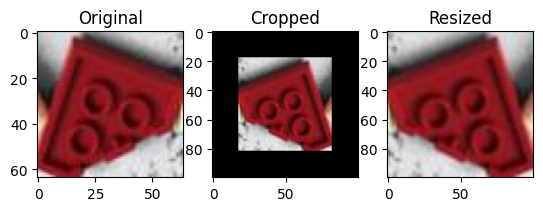

In [ ]:
x, x_label = train_ds[0]
x_cropped, x_label = train_ds_crop[0]
x_resize, x_label = train_ds_resize[0]
fig, axs = plt.subplots(nrows=1, ncols=3)
axs[0].imshow(x.permute(1, 2, 0))
axs[0].set_title('Original')
axs[1].imshow(x_cropped.permute(1, 2, 0))
axs[1].set_title('Cropped')
axs[2].imshow(x_resize.permute(1, 2, 0))
axs[2].set_title('Resized')

plt.show()

In [ ]:
# Define transformations
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),  # Resize to 224x224
    T.ToTensor(),  # Convert to PyTorch Tensor
    # Normalize with ImageNet mean and std
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_ds = CustomImageDataset(train_files, class_to_idx, transform)
val_ds = CustomImageDataset(val_files, class_to_idx, transform)
test_ds = CustomImageDataset(test_files, class_to_idx, transform)

In [ ]:
batch_size = 64

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [ ]:
import timm
model = timm.create_model('efficientnet_b0', pretrained = True)

In [ ]:
#model = timm.create_model('tf_efficientnet_b4_ns', pretrained = True)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(in_features = 1280, out_features = 625),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(in_features = 625, out_features = 10)
)

In [ ]:
num_epochs = 10
learning_r = 0.001
loss_f = nn.CrossEntropyLoss()
## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr = learning_r)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

In [ ]:
def train(model,
          loss_f,
          optimizer,
          scheduler,
          n_epoch=50,
          train_dataloader=train_loader,
          val_dataloader=val_loader,
          test_dataloader=test_loader,
          seed_value=None):
    """

    """
    if seed_value:
        torch.manual_seed(seed_value)

    model.to(device)

    epoch_loss = []
    epoch_acc = []

    for epoch in range(n_epoch):
        model.train()
        total_loss = 0
        train_corr_pred = 0
        train_total = 0

        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            # forward pass and loss
            output = model(images)
            loss = loss_f(output, labels)
            # backward propagation and update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            train_pred = output.max(1).indices
            train_corr_pred += (train_pred == labels).sum().item()
            train_total += labels.size(0)

        train_accuracy = train_corr_pred / train_total
        epoch_loss.append(total_loss)

        model.eval()
        val_corr_pred = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)

                output = model(images)
                val_pred = output.max(1).indices
                val_corr_pred += (val_pred == labels).sum().item()
                val_total += labels.size(0)
            val_accuracy = val_corr_pred / val_total
            epoch_acc.append(val_accuracy)
        scheduler.step()
        print(f"epoch {epoch+1}/{n_epoch} Training accuracy:{train_accuracy}  Validation accuracy:{val_accuracy}")

    model.eval()
    test_corr_pred = 0
    test_total = 0

    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        test_pred = output.max(1).indices
        test_corr_pred += (test_pred == labels).sum().item()
        test_total += labels.size(0)
    test_accuracy = test_corr_pred / test_total
    print(f"Test accuracy:{test_accuracy}")

    return epoch_loss, epoch_acc

In [ ]:
output = train(model, loss_f, optimizer, scheduler, n_epoch = num_epochs,
               train_dataloader = train_loader,
               val_dataloader = val_loader,
               test_dataloader = test_loader,
               seed_value = None)